**Question: is it possible to predict the number of followers [followers_count] that a person will have on Twitter, based on their other attributes? **

A user's attributes include:
- When the account was created [created_at]: probably super important. The longer someone has been a user for, likely the more followers they have
- Whether or not they have a profile image [default_profile_image]. I'd expect users with a profile image to have more followers
- Description: Could length of description make a difference?
- favourites_count: More active users could favourite more, and also have more followers?
- following: Could potentially be a positive correlation between followers and following, although not necessarily; some very popular accounts are following very few people
- lang: I'd expect users using english/spanish to have more followers
- statuses_count: people with more statuses are more active users, and probably have more followers
- verified: More likely to be a real human
- withheld_in_countries: users with witheld profile possibly have fewer followers?

How many data points do I need for my model? Some sources state at least 20 observations per vairable as a general rule of thunb. How many user profiles can I pull from Twitter in a reasonable amount of time?


Should I get my users from a particular source, or can I just pull them randomly from Twitter?

In [372]:
import twitterscrape
import tweepy
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import powerlaw
import math
import numpy as np
from __future__ import division
from sklearn.cross_validation import train_test_split
%matplotlib inline

In [165]:
api = twitterscrape.authenticate()

In [166]:
#This gets all of the ids for the followers of the RC
ids = []
for page in tweepy.Cursor(api.followers_ids, screen_name="recursecenter").pages():
    ids.extend(page)
    time.sleep(60)

In [167]:
len(ids)


17548

Twitter places [limits](https://dev.twitter.com/rest/public/rate-limits) on how many times you can ping them per 15 minutes. [GET Users/Lookup](https://dev.twitter.com/rest/reference/get/users/lookup) returns up to 100 users per request. I am allowed to send 180 Lookup requests per 15 minutes = 18000 users per 15 minutes. So I should be able to do them all no problem in one 15 minute block, no token bucket required.

In [168]:
ids[0]

100408795

In [169]:
def get_users(ids):
    last_index = 0
    results = []
    for i in range(100,len(ids),100):
        result = api.lookup_users(ids[last_index:i])
        
        last_index = i
        results.append(result)
    return results

In [170]:
RC_followers = get_users(ids)

In [171]:
len(RC_followers)

175

In [180]:
RC_followers_concat =  [inner 
                        for outer in RC_followers 
                        for inner in outer]

In [209]:
#this is a way of getting attributes from 
getattr(RC_followers_concat[0],'name')

u'Dave Bryand'

In [211]:
columns_list = ["name", "created_at","default_profile_image", "description", "favourites_count", "followers_count", "friends_count", "lang", "listed_count", "protected", "statuses_count", "time_zone", "verified", "withheld_in_countries"]

In [214]:
#create a dictionary using columns where every key contains a list
user_dict = {column:[getattr(user,column) if hasattr(user,column) else None for user in RC_followers_concat] for column in columns_list}
RC_followers_df = pd.DataFrame(user_dict)

In [223]:
RC_followers_df.head()

,created_at,default_profile_image,description,favourites_count,followers_count,friends_count,lang,listed_count,name,protected,statuses_count,time_zone,verified,withheld_in_countries
0,2009-12-30 04:56:18,False,WorkLife Co-founder. On fire about building th...,261,291,704,en,14,Dave Bryand,False,532,Pacific Time (US & Canada),False,None
1,2011-01-23 23:30:47,False,unpopular dolt,9,24,131,en,1,Nimrod Dancer,False,758,Eastern Time (US & Canada),False,None
2,2015-06-30 15:05:36,False,an ardent machine learner. #machinelearning #n...,51,116,223,en,10,Mallikarjun Yelameli,False,60,None,False,None
3,2011-12-13 00:22:03,False,farm-to-table data science,213,25,407,en,2,jawn,False,89,Pacific Time (US & Canada),False,None
4,2011-12-11 05:01:42,False,,120,51,202,en,3,Stewart Stewart,False,35,Arizona,False,None


##Analysis

I first plotted a histogram to see the distribution of the number of followers for each user

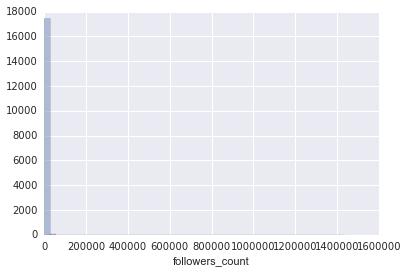

In [323]:
sns.distplot(RC_followers_df.followers_count, kde = False)

I suspect that this is showing a heavy-tailed distribution; there are lots and lots of people with few followers, and a small number of people with may followers; hence, the strange looking plot

In [232]:
RC_followers_df[RC_followers_df.followers_count == RC_followers_df.followers_count.max()]

,created_at,default_profile_image,description,favourites_count,followers_count,friends_count,lang,listed_count,name,protected,statuses_count,time_zone,verified,withheld_in_countries
12994,2008-07-31 06:04:28,False,Trying to Find People Online? Try #PeopleSearc...,6536,1437440,55896,en,473,PeopleSearches.com,False,45529,Pacific Time (US & Canada),False,None


The user with the most followers has 1.4 million followers! A website that specialises in finding people online

In [408]:
len(RC_followers_df[RC_followers_df.followers_count>10000])

171

There are 171 users with >10000 followers

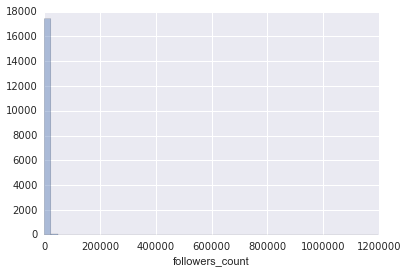

In [413]:
#Does it make a difference if I drop that really high value?
RC_followers_df_cleaned = RC_followers_df.drop(12994)
sns.distplot(RC_followers_df_cleaned.followers_count, kde = False)

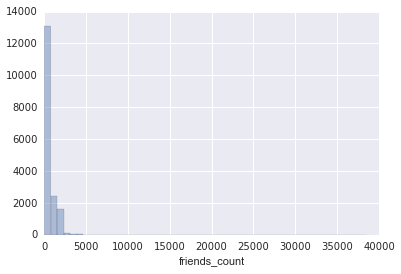

In [412]:
#get rid of people with less than 10,000 followers
sns.distplot(RC_followers_df[RC_followers_df.followers_count<10000].friends_count, kde = False)

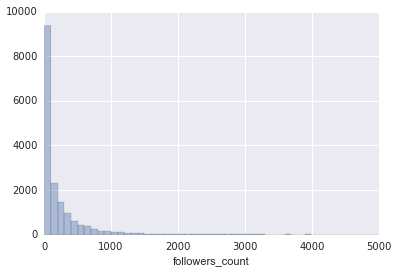

In [263]:
#Less than 5000 followers
sns.distplot(RC_followers_df.followers_count[RC_followers_df.followers_count<5000], kde = False)

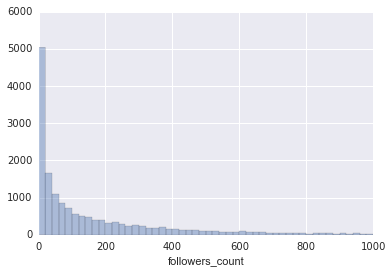

In [264]:
#Less than 1000 followers
sns.distplot(RC_followers_df.followers_count[RC_followers_df.followers_count<1000], kde = False)

In [265]:
sum(RC_followers_df.followers_count)

17450052

##Modelling heavy-tailed distributions
Use the powerlaw package to model the distribution

In [283]:
len(RC_followers_df[RC_followers_df.followers_count==0])/len(RC_followers_df)
#only 4% users have no followers

0.04222857142857143

In [349]:
#Get rid of these 0 values
RC_followers_df_nozero = RC_followers_df[RC_followers_df.followers_count!=0]

In [351]:
#fit the distribution using the powerlaw package
fit = powerlaw.Fit(RC_followers_df_nozero.followers_count)

Calculating best minimal value for power law fit


In [312]:
#alpha is the The parameter of the power law. This is the slope on a log-log plot.
fit.power_law.alpha

1.8786777775094308

In [321]:
#xmin shows the minimum value at which the power law starts
fit.power_law.xmin

1196.0

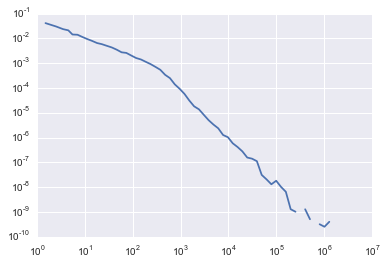

In [292]:
#probability density function for the data. Note the kink at around 10^2, around the point of xmin
powerlaw.plot_pdf(RC_followers_df_nozero.followers_count)

In [414]:
#Comparison of which is the better fit: power law or exponential. Power law is better fit
R, p = fit.distribution_compare("power_law","exponential", normalized_ratio=True)
print R, p

6.58898688778 4.42837889919e-11


In [301]:
#Exponential vs. lognormal. Lognormal is better
R, p = fit.distribution_compare("exponential","lognormal")
print R, p

-1153.57161293 3.87510028386e-11


In [299]:
#Powerlaw vs lognormal. No significant difference
R, p = fit.distribution_compare("power_law", "lognormal")
print R, p

-0.274291308296 0.667339520204


There isn't a significant difference between the likelihood of power law and lognormal distributions. Lognormal is a simpler distribution and so I assume this is more likely

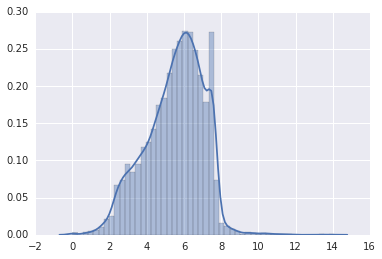

In [337]:
#Log transformed distribution looks like this. 
sns.distplot([math.log(count) for count in RC_followers_df.friends_count if count>0], bins =50)

##Feature engineering

In [384]:
RC_followers_df_nozero['Length_of_membership'] = pd.to_datetime('2015-12-03 18:12:46') - RC_followers_df_nozero['created_at']


/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [402]:
current_date = pd.to_datetime('2015-12-03 18:12:46')

In [403]:
#Add in column that quantifies length of membership in days
RC_followers_df_nozero['Length_of_membership'] = RC_followers_df_nozero['created_at'].apply(lambda x:(current_date-x).days)

/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [405]:
#split dataset up into train and test sets for cross-validation
mask = np.random.rand(len(RC_followers_df_nozero))<0.8
RC_train = RC_followers_df_nozero[mask]
RC_test = RC_followers_df_nozero[~mask]

In [344]:
#Save to csv
RC_followers_df.to_csv("RC_followers_df.csv", encoding = 'utf-8')
RC_train.to_csv("RC_train.csv", encoding = 'utf-8')
RC_test.to_csv("RC_test.csv", encoding = 'utf-8')